In [1]:
import tensorflow as tf
#tf.enable_eager_execution()

In [2]:
from parameters import *
#from helper import *
#from model import model

import cv2

import imageio
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import keras
import numpy as np
import tensorflow_addons as tfa
from scipy import ndimage, misc

#tf.enable_eager_execution()

In [24]:
def save_tf_image(path,image_array) :
    return tf.keras.preprocessing.image.save_img(path,image_array)


def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def extract_data(filename, num_images):
    """Extract the images into a 4D tensor [image index, y, x, channels].
    Values are rescaled from [0, 255] down to [-0.5, 0.5].
    """
    imgs = []
    for i in range(1, num_images+1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if load_image(image_filename):
            print('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            imgs.append(img)
        else:
            print('File ' + image_filename + ' does not exist')

    num_images = len(imgs)
    IMG_WIDTH = imgs[0].shape[0]
    IMG_HEIGHT = imgs[0].shape[1]
    N_PATCHES_PER_IMAGE = (IMG_WIDTH/IMG_PATCH_SIZE)*(IMG_HEIGHT/IMG_PATCH_SIZE)

    img_patches = [img_crop(imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = [img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))]

    return np.asarray(data)

def extract_data_TF(filename, num_images) : 

    return tf.keras.preprocessing.image_dataset_from_directory(
        filename, labels='inferred', label_mode='int',
        class_names=None, color_mode='rgb', batch_size=20, image_size=(400,
        400), shuffle=True, seed=1, validation_split=None, subset=None,
        interpolation='bilinear', follow_links=False
    )


# Extract label images
def extract_labels(filename, num_images):
    """Extract the labels into a 1-hot matrix [image index, label index]."""
    gt_imgs = []
    for i in range(1, num_images + 1):
        imageid = "satImage_%.3d" % i
        image_filename = filename + imageid + ".png"
        if os.path.isfile(image_filename):
            print('Loading ' + image_filename)
            img = mpimg.imread(image_filename)
            gt_imgs.append(img)
        else:
            print('File ' + image_filename + ' does not exist')

    num_images = len(gt_imgs)
    gt_patches = [img_crop(gt_imgs[i], IMG_PATCH_SIZE, IMG_PATCH_SIZE) for i in range(num_images)]
    data = np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])
    labels = np.asarray([value_to_class(np.mean(data[i])) for i in range(len(data))])

    # Convert to dense 1-hot representation.
    return labels.astype(np.float32)

def img_crop(im, w, h):
    list_patches = []
    imgwidth = im.shape[0]
    imgheight = im.shape[1]
    is_2d = len(im.shape) < 3
    for i in range(0, imgheight, h):
        for j in range(0, imgwidth, w):
            if is_2d:
                im_patch = im[j:j+w, i:i+h]
            else:
                im_patch = im[j:j+w, i:i+h, :]
            list_patches.append(im_patch)
    return list_patches


    # Assign a label to a patch v
def value_to_class(v):
    foreground_threshold = 0.25  # percentage of pixels > 1 required to assign a foreground label to a patch
    df = np.sum(v)
    if df > foreground_threshold:  # road
        return [0, 1]
    else:  # bgrd
        return [1, 0]

    
    #1-hot = que des zeros sauf un 1

def add_gaussian_noise(image):
    # image must be scaled in [0, 1]
    with tf.name_scope('Add_gaussian_noise'):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=(25)/(255), dtype=tf.float32) #initially stddev=(50)/(255)
        noise_img = image + noise
        noise_img = tf.clip_by_value(noise_img, 0.0, 1.0)
    return noise_img


In [5]:
TRAINING_SIZE = 10
data_dir = data_dir = 'ressource_files/test_folder/training/'
image_dir = data_dir + 'images/'
groundt_dir = data_dir + 'groundtruth/'
print(os.listdir(image_dir)) #return list of files of a directory
print(os.listdir(image_dir)) #return list of files of a directory


['satImage_052.png', 'satImage_046.png', 'satImage_091.png', 'satImage_085.png', 'satImage_084.png', 'satImage_090.png', 'satImage_047.png', 'satImage_053.png', 'satImage_045.png', 'satImage_051.png', 'satImage_079.png', 'satImage_086.png', 'satImage_092.png', 'satImage_093.png', 'satImage_087.png', 'satImage_078.png', 'satImage_050.png', 'satImage_044.png', 'satImage_068.png', 'satImage_040.png', 'satImage_054.png', 'satImage_083.png', 'satImage_097.png', 'satImage_096.png', 'satImage_082.png', 'satImage_055.png', 'satImage_041.png', 'satImage_069.png', 'satImage_057.png', 'satImage_043.png', 'satImage_094.png', 'satImage_080.png', 'satImage_081.png', 'satImage_095.png', 'satImage_042.png', 'satImage_056.png', 'satImage_031.png', 'satImage_025.png', 'satImage_019.png', 'satImage_018.png', 'satImage_024.png', 'satImage_030.png', 'satImage_026.png', 'satImage_032.png', 'satImage_033.png', 'satImage_027.png', 'satImage_023.png', 'satImage_037.png', 'satImage_036.png', 'satImage_022.png',

In [26]:
TRAINING_SIZE = 10
data_dir = 'ressource_files/test_folder/training/'
image_dir = data_dir + 'images/'
groundt_dir = data_dir + 'groundtruth/'

files = os.listdir(image_dir) #return rdm list of files of a directory
images_list = [load_image(image_dir + files[i]) for i in range(TRAINING_SIZE)] # create list of the names of the images 
groundt_list = [load_image(groundt_dir + files[i]) for i in range(TRAINING_SIZE)]   # create list of the names of the groundtruth (images and groundtruth names are the same)

num_aug = TRAINING_SIZE + 1 



for i in range(TRAINING_SIZE) :
    j = i+1

    # load images
    img = images_list[i]
    groundt = groundt_list[i]
    groundt = np.expand_dims(groundt, axis=2)

    #rot90
    rot90_i = tf.image.rot90(img)
    rot90_gt = tf.image.rot90(groundt)
    save_tf_image(image_dir + 'satImage_' + str(j).zfill(3) + 'rot90.png', rot90_i)
    save_tf_image(groundt_dir + 'satImage_' + str(j).zfill(3) + 'rot90.png', rot90_gt)
    num_aug+=1

    #rot180
    rot180_i = tf.image.rot90(rot90_i)
    rot180_gt = tf.image.rot90(rot90_gt)
    save_tf_image(image_dir + 'satImage_' + str(j).zfill(3) + 'rot180.png', rot180_i)
    save_tf_image(groundt_dir + 'satImage_' + str(j).zfill(3) + 'rot180.png', rot180_gt)
    num_aug+=1

    #rot270
    rot270_i = tf.image.rot90(rot180_i)
    rot270_gt = tf.image.rot90(rot180_gt)
    save_tf_image(image_dir + 'satImage_' + str(j).zfill(3) + 'rot270.png', rot270_i)
    save_tf_image(groundt_dir + 'satImage_' + str(j).zfill(3) + 'rot270.png', rot270_gt)
    num_aug+=1

    #vertical flip
    save_tf_image(image_dir + 'satImage_' + str(j).zfill(3) + 'vertflip.png', tf.image.flip_left_right(img))
    save_tf_image(groundt_dir + 'satImage_' + str(j).zfill(3) + 'vertflip.png', tf.image.flip_left_right(groundt))
    num_aug+=1


    #horizontal flip
    save_tf_image(image_dir + 'satImage_' + str(j).zfill(3) + 'horflip.png', tf.image.flip_up_down(img))
    save_tf_image(groundt_dir + 'satImage_' + str(j).zfill(3) + 'horflip.png', tf.image.flip_up_down(groundt))
    num_aug+=1

    #45° flip
    rot45_flip_i = tf.image.flip_up_down(tfa.image.rotate(img,(np.pi)/4))
    central_crop_i = tf.image.central_crop(rot45_flip_i,0.7)
    rot45_flip_gt = tf.image.flip_up_down(tfa.image.rotate(groundt,(np.pi)/4))
    central_crop_gt = tf.image.central_crop(rot45_flip_gt,0.7)
    save_tf_image(image_dir + 'satImage_' + str(j).zfill(3) + '_45flip.png', tf.image.resize(central_crop_i, [400,400], method = 'bilinear',preserve_aspect_ratio=True,antialias = True))
    save_tf_image(groundt_dir + 'satImage_' + str(j).zfill(3) + '_45flip.png', tf.image.resize(central_crop_gt, [400,400], method = 'bilinear',preserve_aspect_ratio=True,antialias = True))

    #135° flip
    rot135_flip_i = tf.image.flip_up_down(tfa.image.rotate(img,-(np.pi)/4))
    central_crop_i = tf.image.central_crop(rot135_flip_i,0.7)
    rot135_flip_gt = tf.image.flip_up_down(tfa.image.rotate(groundt,-(np.pi)/4))
    central_crop_gt = tf.image.central_crop(rot135_flip_gt,0.7)
    save_tf_image(image_dir + 'satImage_' + str(j).zfill(3) + '_135flip.png', tf.image.resize(central_crop_i, [400,400], method = 'bilinear',preserve_aspect_ratio=True,antialias = True,))
    save_tf_image(groundt_dir + 'satImage_' + str(j).zfill(3) + '_135flip.png', tf.image.resize(central_crop_gt, [400,400], method = 'bilinear',preserve_aspect_ratio=True,antialias = True))

    #add noise 
    save_tf_image(image_dir + 'satImage_' + str(j).zfill(3) + 'noise.png', add_gaussian_noise(img))
    save_tf_image(groundt_dir + 'satImage_' + str(j).zfill(3) + 'noise.png', groundt)
    num_aug+=1




    #centering



In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  'ressource_files/test_folder/training/images/',
  validation_split=0.2,
  subset="training",
  label_mode = None,
  seed=123,
  image_size=(400, 400),
  batch_size=10)


Found 0 files belonging to 0 classes.
Using 0 files for training.


TypeError: Input 'filename' of 'ReadFile' Op has type float32 that does not match expected type of string.

tf.Tensor(
[[[0.38431373]
  [0.38431373]
  [0.38431373]
  ...
  [0.92941177]
  [0.92941177]
  [0.92941177]]

 [[0.92941177]
  [0.92941177]
  [0.92941177]
  ...
  [0.92941177]
  [0.92941177]
  [0.92941177]]

 [[0.9137255 ]
  [0.9137255 ]
  [0.9137255 ]
  ...
  [0.92941177]
  [0.92941177]
  [0.92941177]]

 ...

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]

 [[0.        ]
  [0.        ]
  [0.        ]
  ...
  [0.        ]
  [0.        ]
  [0.        ]]], shape=(400, 400, 1), dtype=float32)


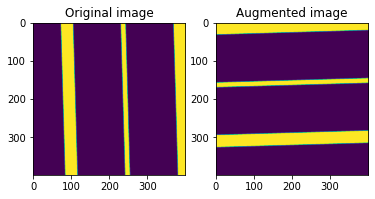

In [19]:


groundt = groundt_list[i]
print(rot90_gt)

groundt = np.expand_dims(groundt, axis=2)

rot90_gt = tf.image.rot90(groundt)
visualize(groundt, rot90_gt)

save_tf_image('ressource_files/test_folder/training/groundtruth/image.png' , rot90_gt)

